In [84]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#导入数据
housedata=fetch_california_housing()
#划分测试集和训练集
train_x,test_x,train_y,test_y=train_test_split(housedata.data,housedata.target,test_size=0.3,random_state=42)
from sklearn.preprocessing import StandardScaler
#标准化处理
scale=StandardScaler()
train_x=scale.fit_transform(train_x)
test_x=scale.fit_transform(test_x)



train_x.shape,train_y.shape,test_x.shape,test_y.shape,max(train_y),min(train_y),max(test_y),min(test_y)

#((14448, 8), (14448,), (6192, 8), (6192,), 5.00001, 0.14999, 5.00001, 0.14999)
#relu 0-x
#复杂分布 Adam

((14448, 8), (14448,), (6192, 8), (6192,), 5.00001, 0.14999, 5.00001, 0.14999)

In [85]:
# Split dataset
def split_list_n_list(origin_list, n):
    if len(origin_list) % n == 0:
        cnt = len(origin_list) // n
    else:
        cnt = len(origin_list) // n + 1
 
    for i in range(0, n):
        yield origin_list[i*cnt:(i+1)*cnt]
#preparing teacher's datasets
n_teachers=10
teacher_x,teacher_y = [],[]
teacher_datasets = []
teacher_data_loader = []



teacher_x_loder = split_list_n_list(train_x,n_teachers)
teacher_y_loder = split_list_n_list(train_y,n_teachers)

teacher_x.extend(iter(teacher_x_loder))
teacher_y.extend(iter(teacher_y_loder))

for i in range(n_teachers):
    print(i,teacher_x[i].shape,teacher_y[i].shape)


from torch.utils.data import TensorDataset, DataLoader
teacher_datasets.extend(TensorDataset(torch.tensor(teacher_x[u],device=device,dtype=torch.float),
                                       torch.tensor(teacher_y[u],device=device,dtype=torch.float))
                        for u in  range(n_teachers))

teacher_data_loader.extend(DataLoader(teacher_datasets[i],batch_size=32,shuffle=True)
                           for i in range(n_teachers))
# print(teacher_x)


print ('preparing students dataset')
student_x,student_y = [] ,[]
student_datasets= []
 

student_x_loder =  split_list_n_list(test_x,2)
student_y_loder =  split_list_n_list(test_y,2)
student_x.extend(iter(student_x_loder))
student_y.extend(iter(student_y_loder))

for i in range(2):
    print(i,student_x[i].shape,student_y[i].shape)

student_datasets.extend(
                        TensorDataset(torch.tensor(student_x[u],device=device,dtype=torch.float),
                                      torch.tensor(student_y[u],device=device,dtype=torch.float))
                        for u in range(2)
)
# model_valid_loader = DataLoader(student_datasets[0], batch_size=len(student_datasets[0]))
student_train_loader = DataLoader(student_datasets[0], batch_size=len(student_datasets[0]),shuffle=True)
student_test_loader = DataLoader(student_datasets[1], batch_size=len(student_datasets[1]))


0 (1445, 8) (1445,)
1 (1445, 8) (1445,)
2 (1445, 8) (1445,)
3 (1445, 8) (1445,)
4 (1445, 8) (1445,)
5 (1445, 8) (1445,)
6 (1445, 8) (1445,)
7 (1445, 8) (1445,)
8 (1445, 8) (1445,)
9 (1443, 8) (1443,)
preparing students dataset
0 (3096, 8) (3096,)
1 (3096, 8) (3096,)


In [86]:
# neural network model mlp
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Sequential(nn.Linear(in_features=8, out_features=256, bias=True),
                                  nn.Dropout(0.7),
                                  nn.ReLU())
        
        self.hidden2 = nn.Sequential(nn.Linear(in_features=256, out_features=64, bias=True),
                                  nn.Dropout(0.7),
                                  nn.ReLU())
        
        self.hidden3 = nn.Sequential(nn.Linear(in_features=64, out_features=16, bias=True),
                                  nn.Dropout(0.5),
                                  nn.ReLU()
                                  )
        
        self.predict = nn.Sequential(nn.Linear(in_features=16, out_features=1, bias=True),
                                        nn.ReLU())
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        output = self.predict(x)
        return output[:, 0]


mlpreg=MLP().to(device)
print(mlpreg)

MLP(
  (hidden1): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): ReLU()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): ReLU()
  )
  (hidden3): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
  )
  (predict): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): ReLU()
  )
)


In [87]:
 
#training configs
num_epochs=4000
batch_size =32
lr =1e-4
#initializing  teachers model
teachers_model = []

for i in range(n_teachers):
    net = mlpreg
    teachers_model.append(net)
 
teacher_optimizers = [torch.optim.Adam(teachers_model[i].parameters(), lr=lr) for i in range(n_teachers)]

In [88]:
#creating teachers folders
def  mkdir_if_missing(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

for i in  range(n_teachers):
    mkdir_if_missing(f'/kolla/ysy/yzh_mlp_8/teacher{i}')

start training number 0 techer!
Number:0 epoch: 1/4000 loss_tea:5.577481729184055
Number:0 epoch: 11/4000 loss_tea:2.768731627414796
Number:0 epoch: 21/4000 loss_tea:2.5714722042677725
Number:0 epoch: 31/4000 loss_tea:2.08078777625074
Number:0 epoch: 41/4000 loss_tea:2.0413066458124605
Number:0 epoch: 51/4000 loss_tea:2.0740521018067857
Number:0 epoch: 61/4000 loss_tea:1.7739996784698593
Number:0 epoch: 71/4000 loss_tea:1.7711341870284822
Number:0 epoch: 81/4000 loss_tea:1.806718201414524
Number:0 epoch: 91/4000 loss_tea:1.5406550547862135
Number:0 epoch: 101/4000 loss_tea:1.5597819889292996
Number:0 epoch: 111/4000 loss_tea:1.3850852629717658
Number:0 epoch: 121/4000 loss_tea:1.3438370750849635
Number:0 epoch: 131/4000 loss_tea:1.2914229373205903
Number:0 epoch: 141/4000 loss_tea:1.3447040373891284
Number:0 epoch: 151/4000 loss_tea:1.2322850920337294
Number:0 epoch: 161/4000 loss_tea:1.184606542678028
Number:0 epoch: 171/4000 loss_tea:1.250958009079666
Number:0 epoch: 181/4000 loss_te

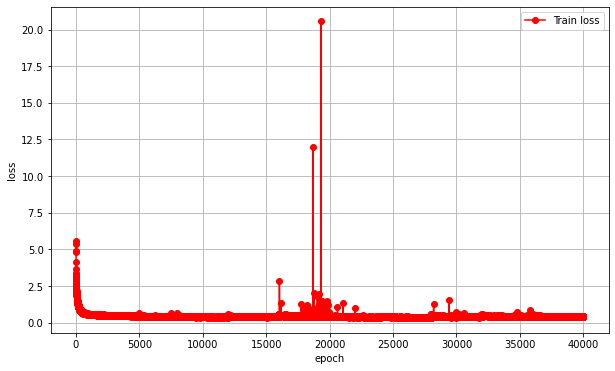

In [89]:
#training teacher models
loss_func=nn.MSELoss()
# loss_all=[[0]*num_epochs]*n_teachers
train_loss_all=[]
for tea_num in range(n_teachers):
    print(f'start training number {tea_num} techer!')
    minloss =float ('inf')
    
    for epoch in range(num_epochs):
        train_loss = 0
        train_num=0
        teachers_model[tea_num].train()
        for b_x,b_y in teacher_data_loader[tea_num]:
            teacher_optimizers[tea_num].zero_grad()
            output=teachers_model[tea_num](b_x.to(device))
            # print(output,b_y)
            loss=loss_func(output.to(device),b_y.to(device))
            loss.backward()
            teacher_optimizers[tea_num].step()
            
            # teacher_optimizers[tea_num].zero_grad()
            # loss_houyan = teachers_model[tea_num].sample_elbo(b_x,b_y,1)
            # loss_houyan.backward()
            # teacher_optimizers[tea_num].step()

            train_loss+=loss.item() * b_x.size(0)
            train_num += b_x.size(0)
            loss_tea = train_loss/train_num
            
            if loss_tea< minloss:
                minloss = loss_tea
            # if loss_houyan< minloss:
            #     minloss = loss_houyan
                if os.path.exists(f'/kolla/ysy/yzh_mlp_8/teacher{tea_num}/best.pth'):
                    os.remove(f'/kolla/ysy/yzh_mlp_8/teacher{tea_num}/best.pth')
                torch.save(teachers_model[tea_num], f'/kolla/ysy/yzh_mlp_8/teacher{tea_num}/best.pth')
        
        
        # loss_all[tea_num][epoch]+=loss
        if epoch%10== 0:
            # print(f'Number:{tea_num}','epoch: {}/{}'.format(epoch+1,num_epochs),f'loss_tea:{loss}', f' loss_houyan:{loss_houyan}')
            print(f'Number:{tea_num}','epoch: {}/{}'.format(epoch+1,num_epochs),f'loss_tea:{loss_tea}')

        train_loss_all.append(loss_tea) 
    print(f'finished training number {tea_num} techer!')
    
plt.figure(figsize=(10,6))
plt.plot(train_loss_all,"ro-",label="Train loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

            
            

In [5]:
# teacher_best_models =[torch.load(f'/kolla/ysy/yzh_mlp_8/teacher{tea_num}/best.pth')  for  tea in  range(n_teachers)]
teacher_best_models =[torch.load(f'/kolla/ysy/yzh_mlp_8/teacher{tea_num}/best.pth')  for  tea_num in  range(n_teachers)]

fz1 =torch.zeros(3096,).to(device)
# print(fz1)
# fz2 =torch.ones(2,3).cuda()
for tea in range(n_teachers):
    for x ,y in student_train_loader:
        teacher_best_models[tea].eval().to(device)
        fz = teacher_best_models[tea](x)
        # print(fz)
    fz1=(fz1+fz)
    
fz1 = fz1/n_teachers
# fz1=fz1/10
print(fz1)
#均值聚合

NameError: name 'n_teachers' is not defined

In [ ]:
a=[1,2,3,4,5]
b= [a[i] for i in range(2)]
print(b)

In [91]:
#student_label
student_trainset =TensorDataset(torch.tensor(student_x[0],device=device,dtype=torch.float),torch.tensor(fz1,device=device,dtype=torch.float))
student_train_loader1 = DataLoader(student_trainset,batch_size=batch_size)
#initialzing student model
student_model=mlpreg
student_optimizer = torch.optim.Adam(student_model.parameters(), lr=3e-5) 

/home/ysy/anaconda3/envs/bayes/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [92]:
#creating student  folders
def  mkdir_if_missing(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

mkdir_if_missing(f'/kolla/ysy/yzh_mlp_8/stu')

In [93]:
#train student model
loss_func=nn.MSELoss()
# 
print('start training')
minloss=float('inf')
for epoch in  range(num_epochs):
    train_loss = 0
    train_num=0
    student_model.train()
    for b_x,b_y in  student_train_loader1:
        student_optimizer.zero_grad()
        output=student_model(b_x)
        loss=loss_func(output,b_y)
        loss.backward()
        student_optimizer.step()
        
        train_loss+=loss.item() * b_x.size(0)
        train_num += b_x.size(0)
        loss_stu = train_loss/train_num
        
        if loss_stu < minloss:
            minloss = loss_stu
            if os.path.exists(f'/kolla/ysy/yzh_mlp_8/stu/best.pth'):
                os.remove(f'/kolla/ysy/yzh_mlp_8/stu/best.pth')
            torch.save(student_model, f'/kolla/ysy/yzh_mlp_8/stu/best.pth')
    if epoch%10 == 0:
        print(f'student train: Epo:{epoch}  Loss_stu:{loss_stu}')
        

start training
student train: Epo:0  Loss_stu:2.4041636136459132
student train: Epo:10  Loss_stu:0.8009117085496277
student train: Epo:20  Loss_stu:0.7609412576185024
student train: Epo:30  Loss_stu:0.3180896560890114
student train: Epo:40  Loss_stu:0.1699360308721084
student train: Epo:50  Loss_stu:0.2127490391333898
student train: Epo:60  Loss_stu:0.12606287772649327
student train: Epo:70  Loss_stu:0.14286885733983312
student train: Epo:80  Loss_stu:0.0990155648623018
student train: Epo:90  Loss_stu:0.06787452531030319
student train: Epo:100  Loss_stu:0.06610283799450219
student train: Epo:110  Loss_stu:0.06557228986067981
student train: Epo:120  Loss_stu:0.060443337236649
student train: Epo:130  Loss_stu:0.05988568144559244
student train: Epo:140  Loss_stu:0.05569859533462414
student train: Epo:150  Loss_stu:0.0699070325308992
student train: Epo:160  Loss_stu:0.05263009999496068
student train: Epo:170  Loss_stu:0.05847740076116505
student train: Epo:180  Loss_stu:0.05141159131622438

In [95]:
#eval  student model
student_best_model =torch.load('/kolla/ysy/yzh_mlp_8/stu/best.pth')

for s_x,s_y in  student_test_loader:
    student_best_model.eval().to(device)
    pred=student_best_model(s_x)
    loss_test=loss_func(pred,s_y) 
print(f'student test Loss:{loss_test}',f'\n predict:{pred}',f'\n b_y:{s_y}')
# array = y.cpu().numpy()
# print(len(s_x))
#找到置信区间 若在student_test_loader中的x的置信度符合该置信区间的 我就加入到新的测试集中，并加入对应标签。训练取loss
# 给各个地方打上标签，对不熟的标签 进行剔除投票 将原有数据集的y标签进行聚合
# student test Loss:0.8320934176445007 

student test Loss:1.294651746749878 
 predict:tensor([2.0040, 2.0199, 1.9673,  ..., 2.0191, 2.0040, 2.0277], device='cuda:0',
       grad_fn=<SelectBackward>) 
 b_y:tensor([2.7500, 2.3850, 1.5830,  ..., 2.1840, 1.1940, 2.0980], device='cuda:0')
